In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path

In [2]:
from src.main_discontinu import *
from src.plot_fields import *

%matplotlib notebook
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)

# Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en QUICK avec Euler explicite en temps.

La référence utilisée est une simulation TOF sur maillage fin.

In [3]:
n_lim = 10**9
t_fin_lim = 1.

In [4]:
from copy import copy

Vtot = 0.02 * 0.005**2

phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)

phy_prop_sans_conv = copy(phy_prop)
phy_prop_sans_conv.v = 0.

num_prop = NumericalProperties(
    dx=4.9 * 10**-5, schema="quick", time_scheme="euler", phy_prop=phy_prop, cfl=1.
)
num_prop_ref = NumericalProperties(
    dx=1.0 * 10**-5, schema="weno", time_scheme="rk3", phy_prop=phy_prop, cfl=1.
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)
# markers = Bulles(phy_prop=phy_prop)

In [5]:
init_params_ref = {
    "markers": markers,
    "phy_prop": phy_prop_sans_conv,
    "num_prop": num_prop_ref,
}
init_params = {"markers": markers, "phy_prop": phy_prop, "num_prop": num_prop}

# Test de l'opérateur ProblemDiscontinuEcomme3D

La simulation est réalisée avec la forme actuelle du code 3D

Dans ce cas là, il n'y a pas de modification des flux calculés en QUICK qui ne sont pas sur des faces coupées. Ainsi les flux qui sont à proximité de l'interface sont calculés avec une interpolation qui prend en compte la valeur de la cellule diphasique.

## Simulation comparée

In [6]:
prob_ref = Problem(
    get_T_creneau, **init_params_ref
)
prob = ProblemDiscontinuEcomme3D(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)

dt fourier
4.538601983461999e-07
Db / dx = 119
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti



ESP 3D


<IPython.core.display.Javascript object>


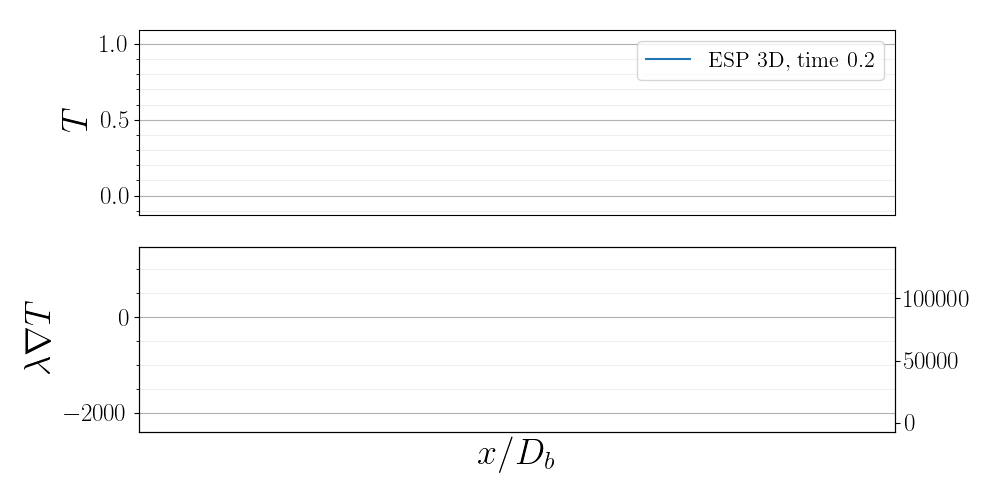

<IPython.core.display.Javascript object>


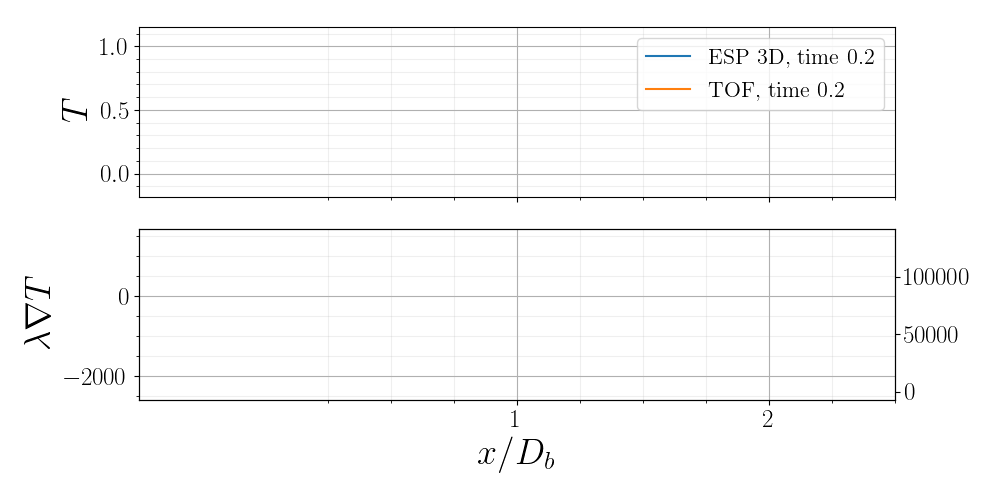

References/prob_ref_t_0.200000.pkl
Reference was loaded


In [7]:
t_fin = 0.2

plot_tot = Plotter("decale", flux_conv=True, lda_gradT=True, zoom=(-0.5,2.5))
plot_1 = Plotter("decale", flux_conv=True, lda_gradT=True, ispretty=False, zoom=(-0.5,2.5))

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

t, e = prob.timestep(
    **time_args, plotter=[plot_1, plot_tot]
)

prob_ref, t_ref, e_ref = load_or_compute(prob_ref, **time_args, plotter=[plot_tot])

<IPython.core.display.Javascript object>


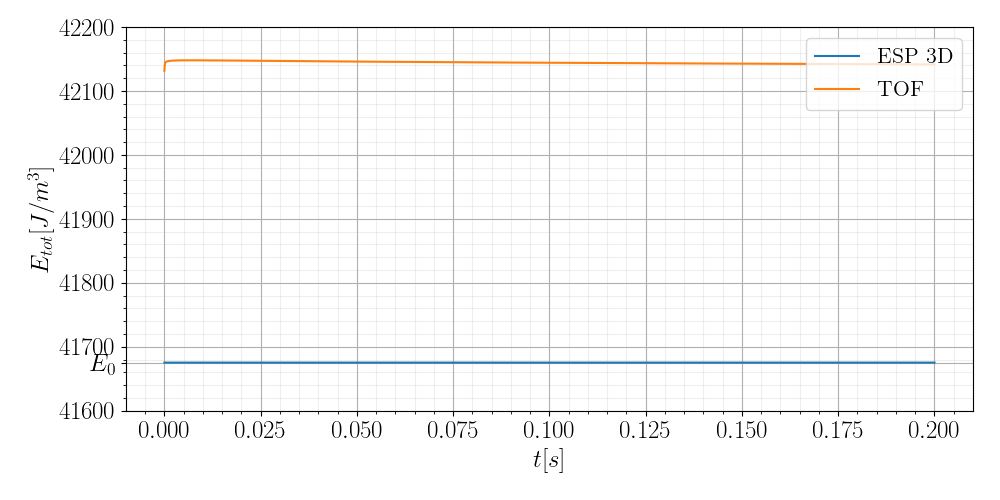


ESP 3D
dE*/dt* = 1.06992e-19

TOF
===
dE*/dt* = -3.32201e-10


In [8]:
plot_en = EnergiePlot()
plot_en.plot_pb(prob, fac=Vtot)
plot_en.plot_pb(prob_ref, fac=Vtot)
plot_en.add_E0()

# Comme 3D avec Ghost cell

Ici on corrige les flux aux faces à proximité de l'interface en utilisant une température ghost.

La résolution se fait à chaque fois en Quick avec Euler explicite en temps.

## Analyse de la correction du flux diffusif sur la solution

### Simulations

Les méthodes fonctionnent de la manière suivante :

- **Problem** :  
    Il s'agit de la référence, TOF sans convection.

- **ProblemDiscontinuComme3D_ghost** :  
    On utilise les valeurs ghosts de la maille diphasique pour corriger les flux convectifs à proximité de
  l'interface (dans le stencil du quick).
    Au corrige donc les flux en $i-1/2$, $i+1/2$ et $i+3/2$.
    Deux choix ont été implémentés :
    - On utilise quick pour $i-1/2$ et $i+3/2$ avec la valeur ghost gauche et droite resp., et une interpolation upwind avec $T_I$ et $\nabla T_{I_{droit}}$ pour $i+1/2$
    - On utilise upwind pour tous
- **ProblemDiscontinuComme3Davecq_ghost** :  
    C'est la meme chose mais on corrige aussi le flux diffusif avec les valeurs de température ghost.
    

In [9]:
prob_ref = Problem(
    get_T_creneau,
    **init_params_ref,
)

prob_gq = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)
prob_gu = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_upwind_ghost",
)
prob_gqd = ProblemDiscontinuEcomme3Davecq_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_ghost",
)

prob_E = ProblemDiscontinuE(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)

prob_Esd = ProblemDiscontinuEsansq(
    get_T_creneau, 
    **init_params, 
    interp_type="Ti",
)


E0 = prob.energy

dt fourier
4.538601983461999e-07
Db / dx = 119
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti


References/prob_ref_t_0.200000.pkl
Reference was loaded


<IPython.core.display.Javascript object>


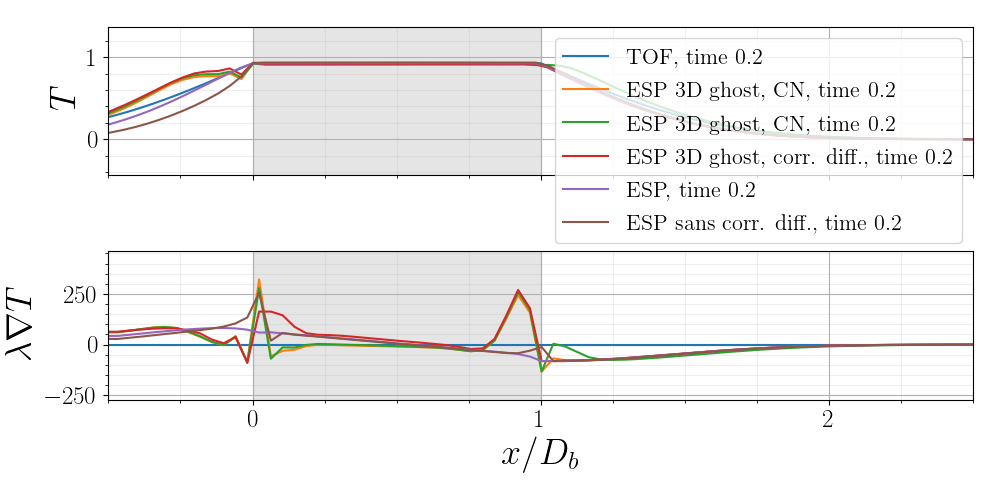


ESP 3D ghost, CN

ESP 3D ghost, CN

ESP 3D ghost, corr. diff.

ESP
===

ESP sans corr. diff.


In [10]:
t_fin = 0.2

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True, zoom=(-0.5, 2.5))

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

prob_ref, t_ref, e_ref = load_or_compute(prob_ref, **time_args, plotter=[plot_tot])

t, e = prob_gq.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

tbis, ebis = prob_gu.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

tacq, eacq = prob_gqd.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

t1, e1 = prob_E.timestep(
    **time_args,
    plotter=[plot_tot],
)

t2, e2 = prob_Esd.timestep(
    **time_args,
    plotter=[plot_tot],
)

Essayer de comprendre pourquoi la version sans diffusion ESP est si loin de la référence.

<IPython.core.display.Javascript object>


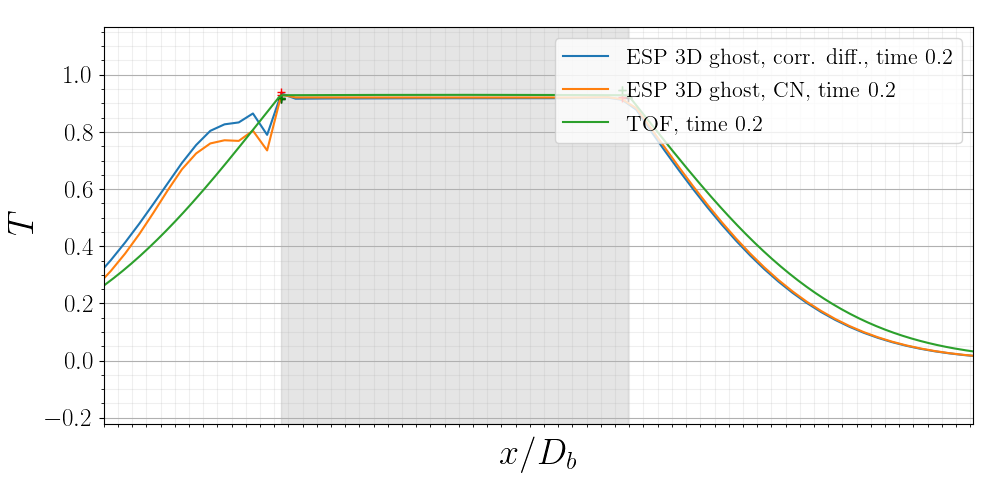

(0.0, 0.003)

In [11]:
plotter = Plotter("decale", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_gqd, plot_Ti=True)
plotter.plot(prob_gq, plot_Ti=True)
plotter.plot(prob_ref)
plotter.ax.set_xlim(0., 0.003)

<IPython.core.display.Javascript object>


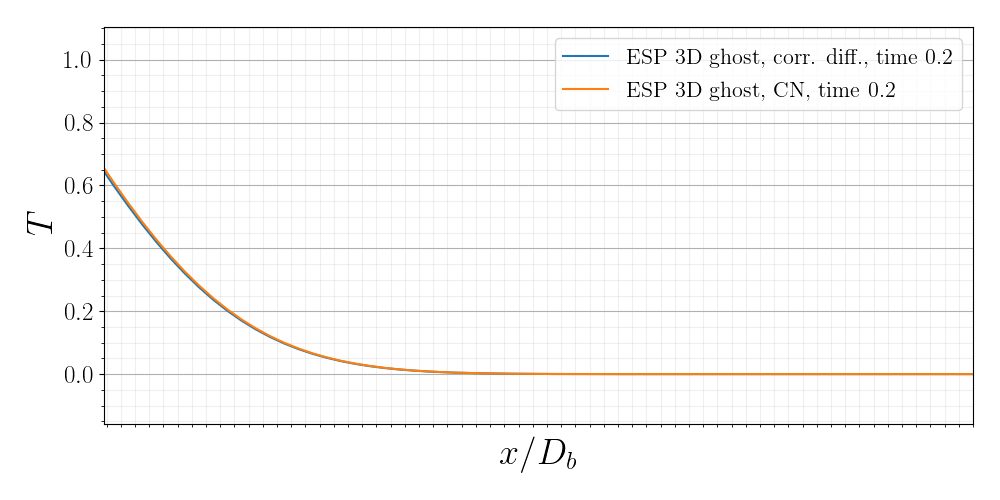

(0.002, 0.005)

In [12]:
plotter = Plotter("classic", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_gqd, plot_Ti=True)
plotter.plot(prob_gq, plot_Ti=True)
plotter.ax.set_xlim(0.002, 0.005)

Vérifier qu'il n'y a pas un glissement de 1 dans le code

<IPython.core.display.Javascript object>


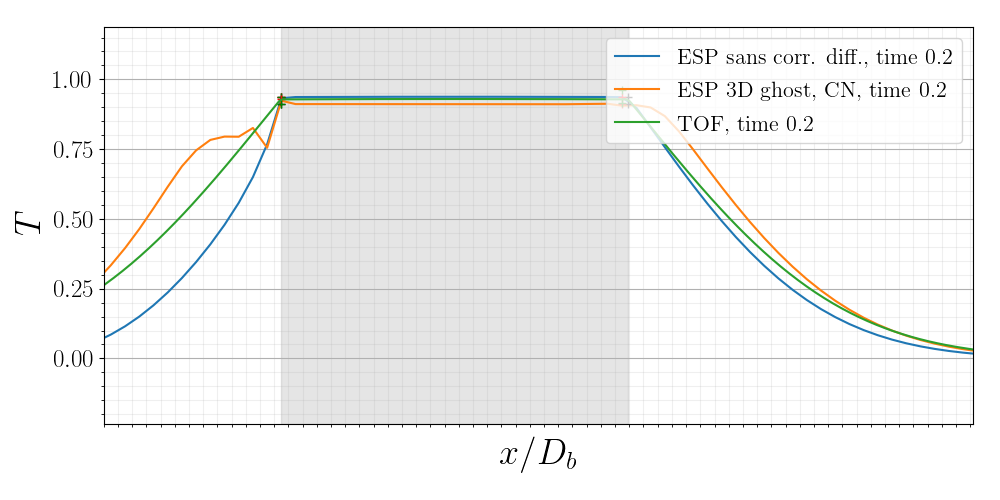

(0.0, 0.003)

In [13]:
plotter = Plotter("decale", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_Esd, plot_Ti=True)
plotter.plot(prob_gu, plot_Ti=True)
plotter.plot(prob_ref)
plotter.ax.set_xlim(0., 0.003)

### Observations

On observe les choses suivantes :
- La différence entre ESP3D quick et ESP3D upwind est minime, on implémentera donc plutôt la version upwind.
- ESP sans corriger le flux diffusif ne donne pas la meme erreur que celle qu'on observe avec ESP3D, je suppose que cette différence vient plutôt de la non intégration exacte en temps de $\rho C_p$ qui est intégré en Crank-Nicolson ($n+ \frac{1}{2}$).
- La version ESP3D avec correction des flux avec différence centrée en utilisant les valeurs ghost droites et gauches ne donne pas de meilleurs résultats que sans cette correction. Pas d'implémentation en 3D donc.

<IPython.core.display.Javascript object>


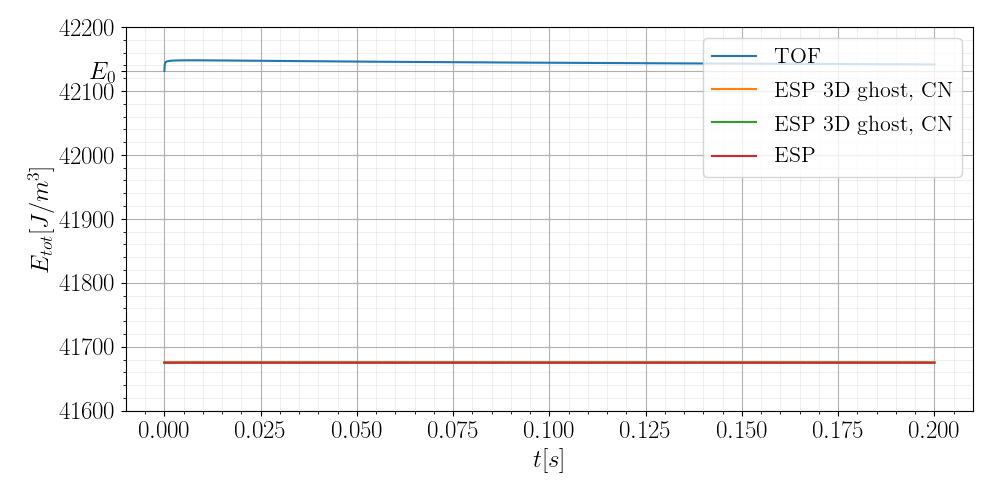


TOF
===
dE*/dt* = -3.28604e-10

ESP 3D ghost, CN
dE*/dt* = 0

ESP 3D ghost, CN
dE*/dt* = -8.2315e-20

ESP
===
dE*/dt* = -4.70371e-20


In [14]:
en_plot = EnergiePlot()
en_plot.plot_pb(prob_ref, fac=Vtot)
en_plot.plot_pb(prob_gq, fac=Vtot)
en_plot.plot_pb(prob_gu, fac=Vtot)
en_plot.plot_pb(prob_E, fac=Vtot)
en_plot.add_E0()

## Analyse de l'effet de l'intégration en temps des surfaces mouillées

Ici on cherche à comprendre la différence entre la référence (TOF sans convection) et le bon résultat (perfectible probablement) obtenu avec la correction des flux ayant recours aux cellules ghosts.

### Paramètres

### Simulations

Les méthodes fonctionnent de la manière suivante :

- **Problem** :  
    Il s'agit de la référence, TOF sans convection.
    
- **ProblemDiscontinuE** :  
    La résolution de référence.
    
- **ProblemDiscontinuE_CN** :  
    La résolution de référence sans l'intégration précise en temps des surfaces mouillées.
    
- **ProblemDiscontinuComme3D_ghost** :  
    On utilise les valeurs ghosts de la maille diphasique pour corriger les flux convectifs à proximité de
  l'interface (dans le stencil du quick).
    On corrige donc les flux en $i-1/2$, $i+1/2$ et $i+3/2$ en upwind.
    
- **ProblemDiscontinuComme3D_ghost_exactSf** :  
    C'est la meme chose mais on calcule les surfaces mouillées en les intégrant exactement (grace au 1D).
    

In [15]:
prob_ref = Problem(
    get_T_creneau,
    **init_params_ref,
)

prob_gu = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_upwind_ghost",
)

prob_guS = ProblemDiscontinuEcomme3D_ghost_exactSf(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
    conv_interf="quick_upwind_ghost",
)

prob_E = ProblemDiscontinuE(
    get_T_creneau,
    **init_params,
    interp_type="Ti",
)

prob_Ecn = ProblemDiscontinuE_CN(
    get_T_creneau, 
    **init_params, 
    interp_type="Ti",
)

dt fourier
4.538601983461999e-07
Db / dx = 119
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti
dt fourier
1.0895003162555343e-05
Db / dx = 24
Ti


References/prob_ref_t_0.200000.pkl
Reference was loaded


<IPython.core.display.Javascript object>


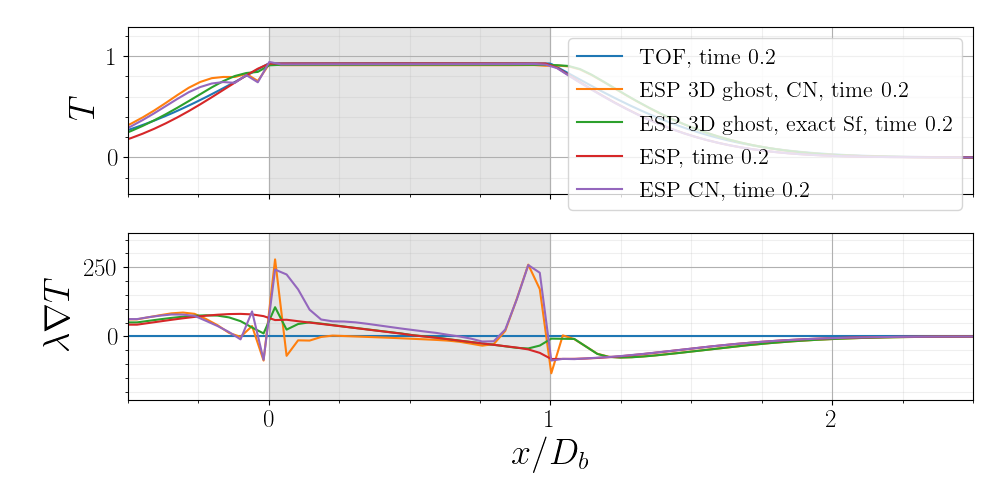


ESP 3D ghost, CN

ESP 3D ghost, exact Sf

ESP
===

ESP CN


In [16]:
t_fin = 0.2

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True, zoom=(-0.5, 2.5))

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

prob_ref, t_ref, e_ref = load_or_compute(prob_ref, **time_args, plotter=[plot_tot])

t, e = prob_gu.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

tbis, ebis = prob_guS.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

te, ee = prob_E.timestep(
    **time_args,
    plotter=[plot_tot],
    plot_Ti=True,
)

te1, ee1 = prob_Ecn.timestep(
    **time_args,
    plotter=[plot_tot],
)

<IPython.core.display.Javascript object>


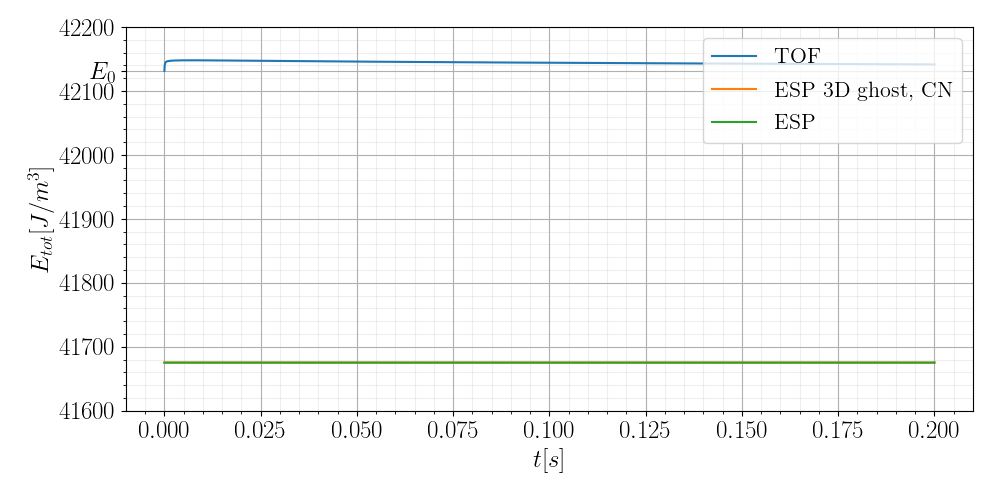


TOF
===
dE*/dt* = -3.28604e-10

ESP 3D ghost, CN
dE*/dt* = -8.2315e-20

ESP
===
dE*/dt* = -4.70371e-20


In [17]:
en_plot = EnergiePlot()
en_plot.plot_pb(prob_ref, fac=Vtot)
en_plot.plot_pb(prob_gu, fac=Vtot)
en_plot.plot_pb(prob_E, fac=Vtot)
en_plot.add_E0()

<IPython.core.display.Javascript object>


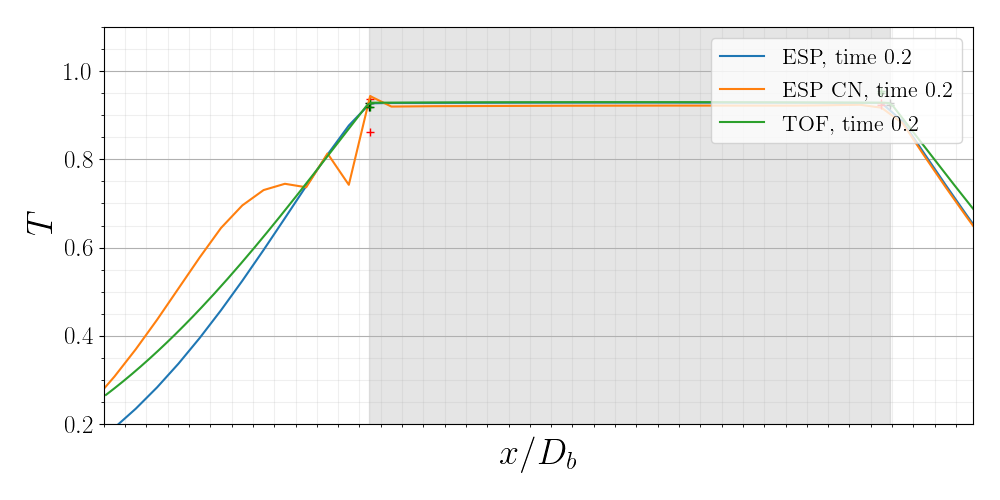

(0.2, 1.1)

In [18]:
plotter = Plotter("decale", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_E, plot_Ti=True)
plotter.plot(prob_Ecn, plot_Ti=True)
plotter.plot(prob_ref)
plotter.ax.set_xlim(0.000, 0.002)
plotter.ax.set_ylim(0.2,1.1)

<IPython.core.display.Javascript object>


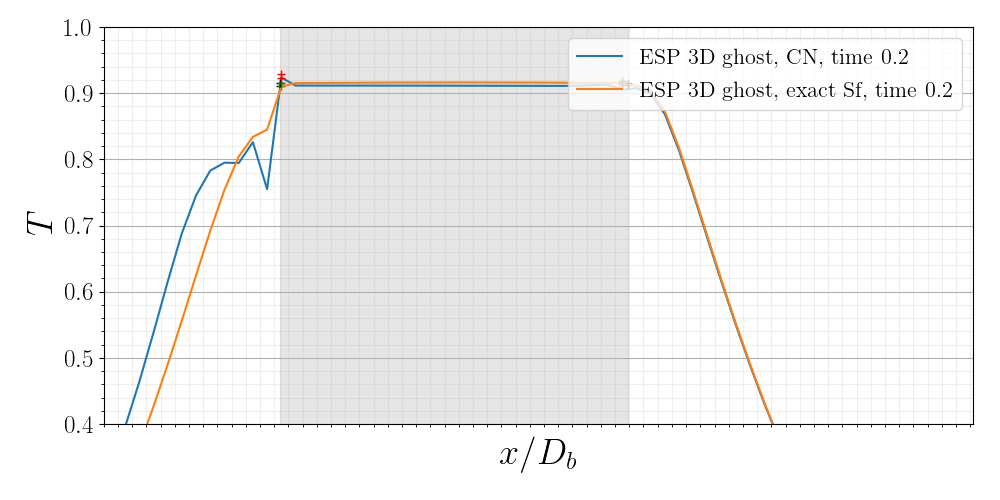

(0.4, 1.0)

In [19]:
plotter = Plotter("classic", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_gu, plot_Ti=True)
plotter.plot(prob_guS, plot_Ti=True)
# plotter.plot(prob_ref)
plotter.ax.set_xlim(0.00, 0.003)
plotter.ax.set_ylim(0.4,1.)

<IPython.core.display.Javascript object>


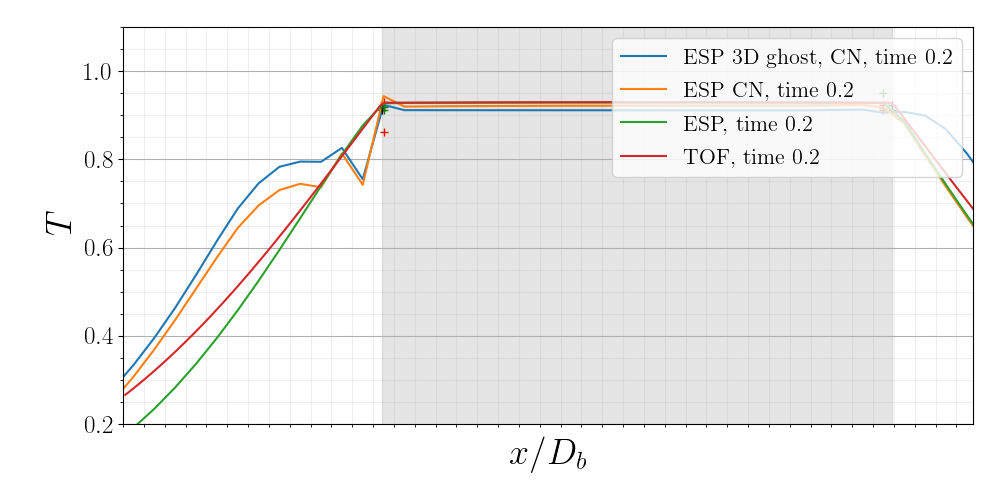

(0.2, 1.1)

In [21]:
plotter = Plotter("decale", flux_conv=False, lda_gradT=False, ispretty=False)
plotter.plot(prob_gu, plot_Ti=True)
plotter.plot(prob_Ecn, plot_Ti=True)
plotter.plot(prob_E)
plotter.plot(prob_ref)
plotter.ax.set_xlim(0.000, 0.002)
plotter.ax.set_ylim(0.2,1.1)

Tester une correction de la diffusion avec la diffusion calculée à l'interface à droite et à gauche. Dans le cas ESP 3D ghost. 

Avantage : cohérence lors du post-traitement entre le flux qu'on récupère et le flux qui est utilisé dans le code.

Vérifier qu'en rafinant la référence on n'observe pas une telle différence entre TOF et ESP sans correction diffusion.

